### Goal

This notebook aims at analyzing the impact of smoke generated from wildfires within a 650-mile radius of Madison, WI, on the health of the community. The main focus is on analyzing the relationship between previously calculated smoke estimates and the respiratory health (illness and mortality of Astham, COPD, and TB) in Madison. Additionally, we will use the forecasted smoke estimates to predict the prevalence and mortality related to the mentioned diseases for the next 25 years so that Madison City Council can stay prepared.

### Licence

The code in the notebook is licensed under standard [MIT licence](https://github.com/ManasaSRonur/data-512-project/blob/main/LICENSE).

Import all the libraries required for data processing, visualizations, statistical analysis, and predictive modeling.

In [237]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import kendalltau


To begin with, we will import historical smoke estimates and forecasted smoke estimates that were generated in previous notebooks.

In [238]:
smoke_df = pd.read_csv('intermediary_files/madison_yearly_smoke_estimate_1964_2024.csv')
forecasted_smoke_df = pd.read_csv('intermediary_files/forecasted_smoke_estimates.csv')
smoke_df.head()

,Fire_Year,Smoke_Estimate
0,1964,0.022558
1,1965,0.309179
2,1966,0.007006
3,1967,0.163549
4,1968,0.008056


To analyze the smoke impact on health, we will import the combined respiratory health data that was generated previously. This dataset contains information both on illness incidents and mortality. We must note that illness data is more relevant to our analysis as it measures at the county level, whereas mortality data is at the state level.

In [239]:
health_df = pd.read_csv('intermediary_files/respiratory_illness_mortality_data.csv')
health_df.head()

,Year,Illness_crude_rate_asthma,Illness_crude_rate_copd,Cases_tb,Death_percent_asthma,Death_percent_copd,Death_percent_tb
0,1980,NaN,NaN,NaN,0.001424,0.026140,0.000874
1,1981,NaN,NaN,NaN,0.001468,0.026540,0.000825
2,1982,NaN,NaN,NaN,0.001598,0.028009,0.000793
3,1983,NaN,NaN,NaN,0.001683,0.030531,0.000764
4,1984,NaN,NaN,NaN,0.001744,0.031926,0.000720


To enbale easy analysis, the health data is merged with historical smoke data.

In [240]:
# Merge dataframes on the column 'Year'
merge_df = pd.merge(health_df, smoke_df, left_on='Year', right_on='Fire_Year', how='inner').drop(columns=['Fire_Year'])
print(merge_df.columns)

Index(['Year', 'Illness_crude_rate_asthma', 'Illness_crude_rate_copd',
       'Cases_tb', 'Death_percent_asthma', 'Death_percent_copd',
       'Death_percent_tb', 'Smoke_Estimate'],
      dtype='object')


One way to understand the impact is to visually compare the smoke and respiratory health statistics of Madison to see if there is any correlation between them. So let us plot graphs for each health statistic against the smoke estimate.

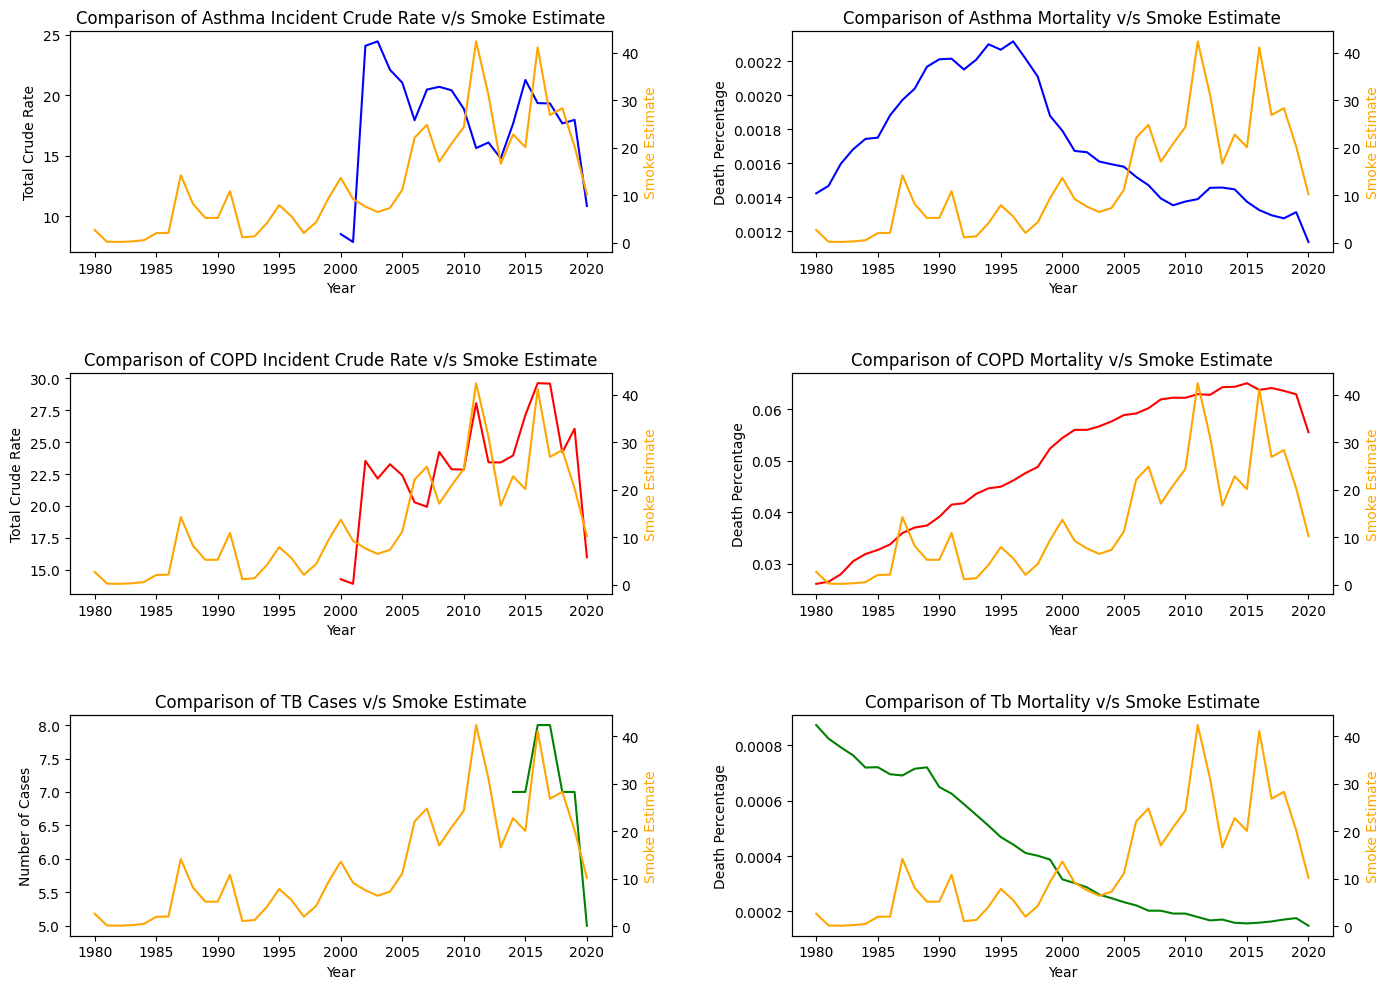

In [241]:

# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Asthma Plots
axs[0, 0].plot(merge_df['Year'], merge_df['Illness_crude_rate_asthma'], color='blue')
axs[0, 0].set_title('Comparison of Asthma Incident Crude Rate v/s Smoke Estimate')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Total Crude Rate')

# Add secondary axis for Smoke_estimate
ax2_0 = axs[0, 0].twinx()
ax2_0.plot(merge_df['Year'], merge_df['Smoke_Estimate'], color='orange')
ax2_0.set_ylabel('Smoke Estimate', color='orange')

axs[0, 1].plot(merge_df['Year'], merge_df['Death_percent_asthma'],  color='blue')
axs[0, 1].set_title('Comparison of Asthma Mortality v/s Smoke Estimate')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Death Percentage')
# Add secondary axis for Smoke_estimate
ax2_1 = axs[0, 1].twinx()
ax2_1.plot(merge_df['Year'], merge_df['Smoke_Estimate'],  color='orange')
ax2_1.set_ylabel('Smoke Estimate', color='orange')

# COPD Plots
axs[1, 0].plot(merge_df['Year'], merge_df['Illness_crude_rate_copd'],  color='red')
axs[1, 0].set_title('Comparison of COPD Incident Crude Rate v/s Smoke Estimate')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Total Crude Rate')
# Add secondary axis for Smoke_estimate
ax2_2 = axs[1, 0].twinx()
ax2_2.plot(merge_df['Year'], merge_df['Smoke_Estimate'], color='orange')
ax2_2.set_ylabel('Smoke Estimate', color='orange')

axs[1, 1].plot(merge_df['Year'], merge_df['Death_percent_copd'],  color='red')
axs[1, 1].set_title('Comparison of COPD Mortality v/s Smoke Estimate')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Death Percentage')
# Add secondary axis for Smoke_estimate
ax2_3 = axs[1, 1].twinx()
ax2_3.plot(merge_df['Year'], merge_df['Smoke_Estimate'],  color='orange')
ax2_3.set_ylabel('Smoke Estimate', color='orange')

# TB Plots
axs[2, 0].plot(merge_df['Year'], merge_df['Cases_tb'], color='green')
axs[2, 0].set_title('Comparison of TB Cases v/s Smoke Estimate')
axs[2, 0].set_xlabel('Year')
axs[2, 0].set_ylabel('Number of Cases')
# Add secondary axis for Smoke_estimate
ax2_4 = axs[2, 0].twinx()
ax2_4.plot(merge_df['Year'], merge_df['Smoke_Estimate'],  color='orange')
ax2_4.set_ylabel('Smoke Estimate', color='orange')

axs[2, 1].plot(merge_df['Year'], merge_df['Death_percent_tb'],  color='green')
axs[2, 1].set_title('Comparison of Tb Mortality v/s Smoke Estimate')
axs[2, 1].set_xlabel('Year')
axs[2, 1].set_ylabel('Death Percentage')
# Add secondary axis for Smoke_estimate
ax2_5 = axs[2, 1].twinx()
ax2_5.plot(merge_df['Year'], merge_df['Smoke_Estimate'],  color='orange')
ax2_5.set_ylabel('Smoke Estimate', color='orange')

plt.tight_layout(h_pad=4, w_pad=4)
plt.show()


Asthma:
Early on, there doesn’t seem to be a strong connection between the two. However, after 2010, their patterns appear more aligned, hinting at a possible link. The mortality rate, on the other hand, shows an opposite trend to smoke estimates—while smoke estimates rose after 2005, asthma deaths declined. This suggests that factors like better healthcare might have played a bigger role in reducing asthma deaths than smoke exposure itself.

COPD:
COPD incidents and deaths show a closer link to smoke estimates than asthma. The incident rate follows a similar trend to smoke estimates, with peaks around 2010 and 2015. Mortality rates also rise as smoke estimates increase, though not perfectly in sync. This suggests smoke exposure could be a key factor affecting both COPD cases and deaths.

Tuberculosis:
Although we have very little data for TB, the available numbers show a strong link to the smoke estimate; the lines are aligned with each other. TB mortality steadily decreased regardless of smoke levels, likely due to better treatment and public health efforts.

The impact of smoke differs across conditions, being more linked to COPD than to asthma. Overall, we see a high correlation between smoke and TB cases, COPD illness incidents, and a moderate correlation between smoke and asthma illness. The graphs for mortality and smoke show very weak correlation. The graph visually highlights the limitations of our dataset. Although we have 40 years of data available for mortality, we do not have a sample size available for illness, especially TB-related illness. This small sample size can interfere without prediction and might even lead to wide confidence intervals. One must consider these caveats while building modeling using this data.


We will now proceed to analyse the strength and directionality of the correlation between smoke estmiate and the other health metrics.

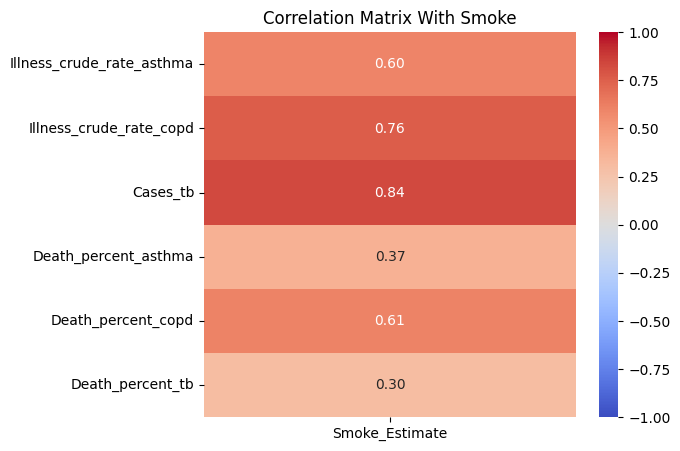

In [242]:
# Analyze correlation between smoke and health metrics
correlation_matrix = merge_df.drop(columns=['Year']).dropna().corr()

# Plot a heatmap
plt.figure(figsize=(6, 5))
h = sns.heatmap(correlation_matrix[['Smoke_Estimate']].iloc[:-1,:], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
# Tilt x-axis labels
plt.title('Correlation Matrix With Smoke')
plt.show()

A value closer to 1 means strong correlation, and a value closer to 0 means weak correlation, and the sign indicates the direction of the correlation. As expected, all of the health metrics have positive correlations, meaning higher the smoke, higher these health metric values with or without causation. However, some of these have weak correlations (all values below 0.5); this could be due to multiple reasons. Smoke is not the only factor that causes poor air quality; additionally, other biological elements contribute to these respiratory illnesses other than toxic air. Due to these confounding variables, the correlations between smoke and these metrics need not be high always.

To build a predictive model, along with historical smoke data, we will need the forecasted smoke data as well. So the next step is to merge these datasets together. Since we do not have any kind of health metrics data available prior to 1980, we will filter the dataset for years 1980 onwards.

In [243]:
# Concatenate actual smoke data with the forecasted smoke data along rows.
smoke_df = pd.concat([smoke_df[['Fire_Year', 'Smoke_Estimate']], forecasted_smoke_df], axis=0)

# Merge the combined smoke data with health data on the year column.
merged_df = smoke_df.merge(health_df, left_on='Fire_Year', right_on='Year', how='left').drop(columns=['Year']).rename(columns={'Fire_Year': "Year"})

merged_df = merged_df[merged_df['Year'] >= 1980]
merged_df.head()

,Year,Smoke_Estimate,Illness_crude_rate_asthma,Illness_crude_rate_copd,Cases_tb,Death_percent_asthma,Death_percent_copd,Death_percent_tb
16,1980,2.681612,NaN,NaN,NaN,0.001424,0.026140,0.000874
17,1981,0.200266,NaN,NaN,NaN,0.001468,0.026540,0.000825
18,1982,0.151609,NaN,NaN,NaN,0.001598,0.028009,0.000793
19,1983,0.268185,NaN,NaN,NaN,0.001683,0.030531,0.000764
20,1984,0.518466,NaN,NaN,NaN,0.001744,0.031926,0.000720


VARMAX (Vector Autoregression Moving-Average with eXogenous variables) is a great fit for this analysis because it can handle multiple time series that influence each other, which aligns well with the interconnected nature of smoke levels and public health metrics. I use a multivariate approach as many of the health metrics are understandably strongly linked. It captures both the relationships between these variables and their own past values, providing a deeper understanding of trends and interactions over time. This makes the model flexible and capable of reflecting real-world dynamics. Additionally, its moving-average component helps account for shocks or sudden changes, which are common in our dataset as seen in the graphs. Additionally, it provides a capability to enhance this model in the future by listing any additional external factors that impact the health metrics and we might have access to. Overall, it’s robust for uncovering complex patterns and making meaningful predictions in this case. This model will be used to forecast the illness and mortality prevelance for Asthma, COPD and Tb for future years

We have 6 response variables and only 1 predictor variable for the given small sample of data. This in VARMAX could lead to overfitting given the dataset size is not too large compared to the number of predictors. So grouping the variables into smaller groups helps keep the VARMAX model simple and focused. With fewer, more related variables, the model can better understand the patterns in the data and make more reliable predictions. There are many ways to group, such as by incidents and mortality or by nature of disease. Grouping by health condition is better than combining all incidents and mortality into one because it allows the model to capture relationships unique to each health condition, improving accuracy and clarity. Also, by separating asthma, COPD, and TB, it is easier to analyze how each health condition responds to smoke levels without mixing the data. Overall, this approach helps the model work better and gives clearer results.


This dictionary will be used throughout to build, evaluate the model, and make predictions.

In [244]:
# Dictionary to group endogenous variables (health outcomes) by condition
endog_col_dict = {
    "Asthma": [
        'Death_percent_asthma',
        'Illness_crude_rate_asthma'
    ],
    "COPD": [
        'Death_percent_copd',
        'Illness_crude_rate_copd'
    ],
    "TB": [
        'Cases_tb',
        'Death_percent_tb'
    ]
}

# List of exogenous variables (external factors) that might influence the health conditions
exog_cols = [
    'Smoke_Estimate'
]

We will build and evaluate the model to understand the model robustness before making predictions.
Below metrics are chosen for model evaluation:
1. MAE (Mean Absolute Error) is used to measure the average error, showing how close the predictions are to actual values. 
2. RMSE (Root Mean Square Error) is included to emphasize larger errors, highlighting significant deviations.
3. MAPE (Mean Absolute Percentage Error) is chosen to assess accuracy in percentage terms, making it easier to compare across different variables,
4. R-R-squared is used to evaluate how well the model explains the variability in the data.
5. AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are included to help assess the model's fit while penalizing for overfitting. Both metrics balance model accuracy with complexity—lower values indicate a better trade-off between model fit and the number of parameters used, helping to choose the most efficient model. 

The selected metrics provide a comprehensive evaluation of the model’s performance, and together they provide a well-rounded picture of the model’s effectiveness.

We do not have data beyond 2022, except for asthma, and similarly, we do not have data prior to 2000, except for mortality. To build an unbiased model, the window of 2000–2022 is chosen where we have data for almost all of the response variables.

Visualizing the evaluation metrics allows for a clearer understanding of the model's performance across different dimensions. Plots of actual vs. fitted values help to visually assess how well the model captures the data trends. So we will create a custom function that builds the model, evaluates the model for specified metrics, plots the graphs, and prints the metric values.

In [245]:
def build_and_evaluate(var_name):
    """
    Calculate and display performance metrics for the time series model.
    
    Args:
        var_name (str): Name of the variable being evaluated
    """
    endog_cols = endog_col_dict[var_name]
    
    if var_name == 'TB':
        train_data = merged_df[merged_df['Year'].isin(range(2014, 2022))]
    else:
        # Select training data (2000-2022)
        train_data = merged_df[merged_df['Year'].isin(range(2000, 2022))]
    
    # Standardize the data
    scaler_endog = StandardScaler()
    scaler_exog = StandardScaler()
    
    # Fit the scalers and transform the data
    train_endog_scaled = scaler_endog.fit_transform(train_data[endog_cols])
    train_exog_scaled = scaler_exog.fit_transform(train_data[exog_cols])
    
    #Model order
    order = (2, 2)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            # Fit VARMAX model
            model = VARMAX(train_endog_scaled, exog=train_exog_scaled, order=order)
            results = model.fit(disp=False)
            
            # Get fitted values
            fitted_values = scaler_endog.inverse_transform(results.fittedvalues)
            actual_values = train_data[endog_cols].values
            
            # Calculate metrics
            mae = np.mean(np.abs(fitted_values - actual_values))
            rmse = np.sqrt(np.mean((fitted_values - actual_values)**2))
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            # Calculate R-squared
            ss_res = np.sum((actual_values - fitted_values) ** 2)
            ss_tot = np.sum((actual_values - np.mean(actual_values)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            
            # Get model information criteria
            aic = results.aic
            bic = results.bic
            
            # Print metrics
            print(f"\nModel Performance Metrics for {var_name}:")
            print("-" * 50)
            print(f"Mean Absolute Error (MAE): {mae:.2f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            print(f"R-squared: {r2:.3f}")
            print(f"Akaike Information Criterion (AIC): {aic:.2f}")
            print(f"Bayesian Information Criterion (BIC): {bic:.2f}")
            
            # Plot actual vs fitted values
            plt.figure(figsize=(8, 6))
            for i, col in enumerate(endog_cols):
                plt.subplot(len(endog_cols), 1, i+1)
                plt.plot(train_data['Year'], actual_values[:, i], label='Actual')
                plt.plot(train_data['Year'], fitted_values[:, i], 'r--', label='Fitted')
                plt.title(f'{col} - Actual vs Fitted Values')
                plt.xlabel('Year')
                plt.ylabel('Value')
                plt.legend()
            
            plt.tight_layout(h_pad=4, w_pad=4)
            plt.show()
            
        except Exception as e:
            print(f"Error calculating metrics for {var_name}: {e}")
            return None



Model Performance Metrics for Asthma:
--------------------------------------------------
Mean Absolute Error (MAE): 0.62
Root Mean Square Error (RMSE): 1.32
Mean Absolute Percentage Error (MAPE): 7.23%
R-squared: 0.980
Akaike Information Criterion (AIC): 76.69
Bayesian Information Criterion (BIC): 101.78


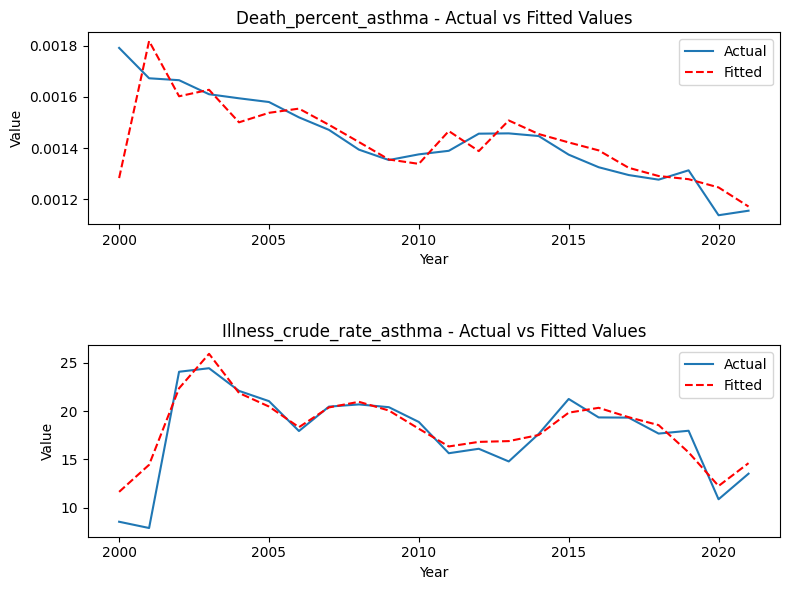

In [246]:
build_and_evaluate('Asthma')

The model performance metrics for Asthma show the following:

1. Mean Absolute Error (MAE) is 0.62, which means that, on average, the model's predictions are off by 0.62 units. This is a relatively low error, indicating good accuracy.
2. Root Mean Square Error (RMSE) is 1.32, which means the model has some larger errors, but it’s still reasonable. Lower RMSE is generally better, so this could be improved.
3. Mean Absolute Percentage Error (MAPE) is 7.23%, showing that the model’s predictions are about 7% off in percentage terms. This is a fairly good value, as lower MAPE indicates higher accuracy.
4. R-squared is 0.980, which is excellent, meaning that 98% of the variation in the data is explained by the model. This is a very good metric.
5. Akaike Information Criterion (AIC) is 76.69 and Bayesian Information Criterion (BIC) is 101.78, both of which are good values, indicating the model balances accuracy and complexity well. Lower values would be better, but these values still suggest a solid model.

Overall, the R-squared is excellent, while RMSE could be improved possibly by adding more external factors.


Model Performance Metrics for COPD:
--------------------------------------------------
Mean Absolute Error (MAE): 0.97
Root Mean Square Error (RMSE): 1.76
Mean Absolute Percentage Error (MAPE): 5.64%
R-squared: 0.977
Akaike Information Criterion (AIC): 97.58
Bayesian Information Criterion (BIC): 122.68


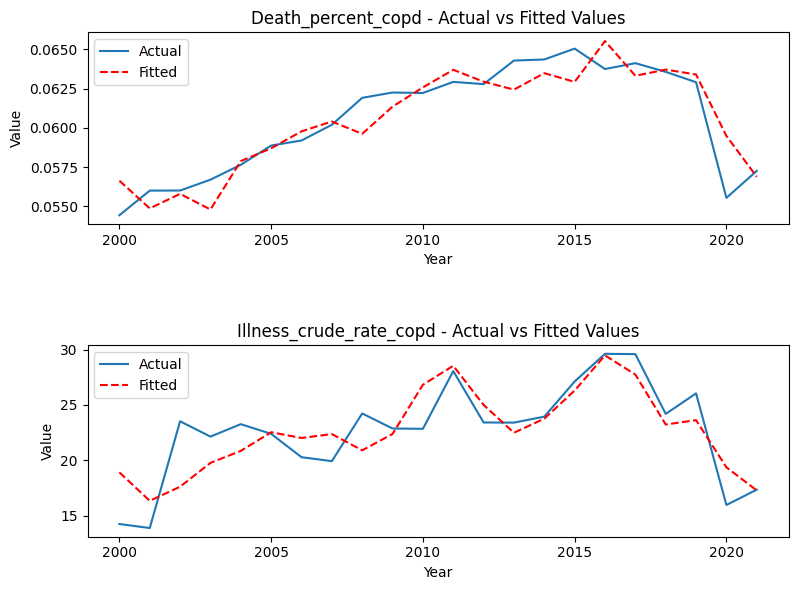

In [247]:
build_and_evaluate('COPD')

The model performance metrics for COPD are as follows:

1. MAE is 0.97, meaning the model’s predictions are, on average, off by almost 1 unit. While this is acceptable, a lower MAE would be better for improved accuracy.
2. RMSE is 1.76, suggesting that the model has some larger errors. This is relatively high, and lowering RMSE would improve model performance.
3. MAPE is 5.64%, which is good, as the model is on average 5.64% off in its predictions. Lower MAPE values are better, but this indicates reasonable accuracy.
4. R-squared is 0.977, meaning the model explains 97.7% of the variation in the data. This is very good and indicates a strong fit.
5. AIC is 97.58 and BIC is 122.68. Both values suggest that the model is balancing fit and complexity well, but lower AIC and BIC values would be ideal.

Overall, R-squared  is excellent, but RMSE could be improved. The MAPE is good, and the AIC and BIC values are acceptable, though slightly higher values would suggest room for improvement in model simplicity.


Model Performance Metrics for TB:
--------------------------------------------------
Mean Absolute Error (MAE): 0.06
Root Mean Square Error (RMSE): 0.14
Mean Absolute Percentage Error (MAPE): 1.79%
R-squared: 0.998
Akaike Information Criterion (AIC): 47.28
Bayesian Information Criterion (BIC): 49.10


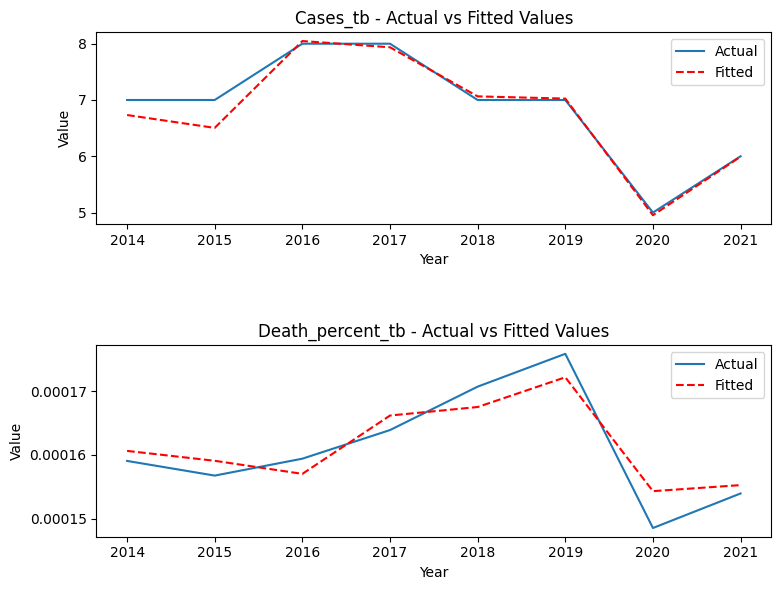

In [248]:
build_and_evaluate('TB')


The model performance metrics for TB are as follows:

1. Mean Absolute Error (MAE) is 0.06, indicating that the model’s predictions are very close to the actual values. This is an excellent result.
2. Root Mean Square Error (RMSE) is 0.14, which is also very low, showing that the model has minimal larger errors. This suggests strong accuracy.
3. Mean Absolute Percentage Error (MAPE) is 1.79%, meaning the model’s predictions are, on average, less than 2% off. This is an excellent metric, indicating very high accuracy.
4. R-squared is 0.998, meaning the model explains 99.8% of the variation in the data. This is outstanding and shows an almost perfect fit.
5. Akaike Information Criterion (AIC) is 47.28, and Bayesian Information Criterion (BIC) is 49.10, both of which are very low, indicating a highly efficient model with a good balance between accuracy and simplicity.

All metrics for TB are excellent, with very low error values, an extremely high R-squared, and low AIC/BIC values. This indicates the model performs exceptionally well for predicting TB-related outcomes.

Overall the VARMAX model seem to be effective for predicting health outcomes, with the TB model showing the highest accuracy and reliability. There is definitely room to further improvement in the Asthma and COPD models, particularly by reducing RMSE and complexity. The varying date range for data availability must also be considered while utilizing the models.

We will now use the VARMAX models to predict the data for the next 25 years. Since we do not have data available for most of these health indicators beyond 2022, we will make predictions from 2023 to 2050. This is a custom function to forecast values for all the health metrics based on the smoke estimate.

In [249]:
def health_forecast(var_name):
    """
    Generate time series forecasts with confidence intervals using VARMAX model.
    
    Args:
        var_name (str): Name of the variable to forecast
        
    Returns:
        pd.DataFrame: Forecast results including mean predictions and confidence intervals
    """
    endog_cols = endog_col_dict[var_name]
    
    # Select data for training (2000–2019) and forecast (2020–2050)
    full_data = merged_df[merged_df['Year'].isin(range(2000, 2022))]
    new_data = merged_df[merged_df['Year'].isin(range(2023, 2051))]
    
    #  Order of the VAR process
    order = (2,2)  
    
    # Standardize the data
    scaler_endog = StandardScaler()
    scaler_exog = StandardScaler()
    
    # Fit the scaler only on columns that are in full_data and new_data
    full_data_endog_scaled = scaler_endog.fit_transform(full_data[endog_cols])
    full_data_exog_scaled = scaler_exog.fit_transform(full_data[exog_cols])
    new_data_exog_scaled = scaler_exog.transform(new_data[exog_cols])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            # Fit the VARMAX model on the scaled training data
            model = VARMAX(full_data_endog_scaled, exog=full_data_exog_scaled, order=order)    
            results = model.fit(disp=False)

            # Forecast future values on the scaled data with confidence intervals
            forecast_steps = len(new_data)
            forecast = results.get_forecast(steps=forecast_steps, exog=new_data_exog_scaled)

            # Extract forecasted means and confidence intervals
            forecast_mean = forecast.predicted_mean
            forecast_ci = forecast.conf_int(alpha=0.1)  # 95% confidence interval

            # Convert forecast mean to DataFrame
            forecast_df = pd.DataFrame(scaler_endog.inverse_transform(forecast_mean), 
                                     columns=endog_cols, 
                                     index=range(2023, 2023 + forecast_steps))
            
            # Transform confidence intervals back to original scale
            # Split CI array into lower and upper bounds
            ci_lower = scaler_endog.inverse_transform(forecast_ci[:, :len(endog_cols)])
            ci_upper = scaler_endog.inverse_transform(forecast_ci[:, len(endog_cols):])
            
            # Create DataFrames for lower and upper bounds
            ci_lower_df = pd.DataFrame(
                ci_lower,
                columns=[f"{col}_lower" for col in endog_cols],
                index=range(2023, 2023 + forecast_steps)
            )
            ci_upper_df = pd.DataFrame(
                ci_upper,
                columns=[f"{col}_upper" for col in endog_cols],
                index=range(2023, 2023 + forecast_steps)
            )

            # Combine forecasts and confidence intervals
            forecast_df = pd.concat([forecast_df, ci_lower_df, ci_upper_df], axis=1)

            # Ensure no forecasted values or CI bounds are below zero
            forecast_df = forecast_df.clip(lower=0)

        except np.linalg.LinAlgError as e:
            print(f"Covariance issue with VARMAX model for {var_name}: {e}")
            return None
        except Exception as e:
            print(f"Error in forecasting for {var_name}: {e}")
            return None
    
    # Add smoke data
    smoke_data = new_data[['Year', 'Smoke_Estimate']].set_index('Year')
    forecast_df = forecast_df.join(smoke_data)
    
    return forecast_df

We will forecast data for each condition individually, beginning with asthma, followed by COPD and TB. Additionally, we will also estimate the 95% Wald-based confidence interval for every forecasted value. To do so, we will simply invoke the above function with the appropriate condition name as a variable.

In [250]:
asthma_df = health_forecast('Asthma')
asthma_df.head()

,Death_percent_asthma,Illness_crude_rate_asthma,Death_percent_asthma_lower,Illness_crude_rate_asthma_lower,Death_percent_asthma_upper,Illness_crude_rate_asthma_upper,Smoke_Estimate
2023,0.001267,14.850782,0.001155,12.852300,0.001379,16.849264,33.207422
2024,0.001346,12.323866,0.001146,9.228617,0.001547,15.419115,34.447835
2025,0.001435,13.345908,0.001181,9.801315,0.001690,16.890502,35.711001
2026,0.001535,15.386585,0.001235,10.636452,0.001836,20.136719,36.996922
2027,0.001625,17.923733,0.001288,11.606187,0.001962,24.241280,38.305597


In [251]:
copd_df = health_forecast('COPD')
copd_df.head()

,Death_percent_copd,Illness_crude_rate_copd,Death_percent_copd_lower,Illness_crude_rate_copd_lower,Death_percent_copd_upper,Illness_crude_rate_copd_upper,Smoke_Estimate
2023,0.057490,13.819278,0.055162,10.703672,0.059819,16.934884,33.207422
2024,0.059249,19.062377,0.056082,15.118996,0.062416,23.005759,34.447835
2025,0.058658,20.448638,0.054896,14.057889,0.062420,26.839388,35.711001
2026,0.059845,22.164674,0.055858,15.233388,0.063832,29.095960,36.996922
2027,0.061317,23.367689,0.056845,16.146426,0.065788,30.588951,38.305597


In [252]:
tb_df = health_forecast('TB')
tb_df.head()

,Cases_tb,Death_percent_tb,Cases_tb_lower,Death_percent_tb_lower,Cases_tb_upper,Death_percent_tb_upper,Smoke_Estimate
2023,6.039682,0.000132,5.104271,0.000124,6.975092,0.000140,33.207422
2024,6.411629,0.000130,5.380703,0.000116,7.442556,0.000145,34.447835
2025,6.356478,0.000133,5.062633,0.000100,7.650322,0.000165,35.711001
2026,6.489421,0.000137,4.971286,0.000094,8.007556,0.000179,36.996922
2027,6.681983,0.000141,4.753666,0.000089,8.610299,0.000192,38.305597


For easy access and analysis, the forecasted data from the years 2023–2050 for all the 3 conditions will be merged into a single dataframe. This approach makes it easier to compare future predictions for asthma, COPD, and TB alongside the projected smoke estimates. Further merging this dataset with future smoke estimates allows for understanding how smoke levels may influence health outcomes in the future.

In [253]:
# Create the future_df by concatenating all disease forecasts
future_df = pd.DataFrame(index=range(2023, 2051))

# Add each disease's forecasts
for df in [asthma_df, copd_df, tb_df]:
    if df is not None:
        for col in df.columns:
            future_df[col] = df[col]

# Add Smoke_Estimate
smoke_data = merged_df[merged_df['Year'].isin(range(2023, 2051))]['Smoke_Estimate'].values
future_df['Smoke_Estimate'] = smoke_data

# Reset index and rename
future_df = future_df.reset_index().rename(columns={'index': 'Year'})
future_df.head()

,Year,Death_percent_asthma,Illness_crude_rate_asthma,Death_percent_asthma_lower,Illness_crude_rate_asthma_lower,Death_percent_asthma_upper,Illness_crude_rate_asthma_upper,Smoke_Estimate,Death_percent_copd,Illness_crude_rate_copd,Death_percent_copd_lower,Illness_crude_rate_copd_lower,Death_percent_copd_upper,Illness_crude_rate_copd_upper,Cases_tb,Death_percent_tb,Cases_tb_lower,Death_percent_tb_lower,Cases_tb_upper,Death_percent_tb_upper
0,2023,0.001267,14.850782,0.001155,12.852300,0.001379,16.849264,33.207422,0.057490,13.819278,0.055162,10.703672,0.059819,16.934884,6.039682,0.000132,5.104271,0.000124,6.975092,0.000140
1,2024,0.001346,12.323866,0.001146,9.228617,0.001547,15.419115,34.447835,0.059249,19.062377,0.056082,15.118996,0.062416,23.005759,6.411629,0.000130,5.380703,0.000116,7.442556,0.000145
2,2025,0.001435,13.345908,0.001181,9.801315,0.001690,16.890502,35.711001,0.058658,20.448638,0.054896,14.057889,0.062420,26.839388,6.356478,0.000133,5.062633,0.000100,7.650322,0.000165
3,2026,0.001535,15.386585,0.001235,10.636452,0.001836,20.136719,36.996922,0.059845,22.164674,0.055858,15.233388,0.063832,29.095960,6.489421,0.000137,4.971286,0.000094,8.007556,0.000179
4,2027,0.001625,17.923733,0.001288,11.606187,0.001962,24.241280,38.305597,0.061317,23.367689,0.056845,16.146426,0.065788,30.588951,6.681983,0.000141,4.753666,0.000089,8.610299,0.000192


We now have everything we wanted in a single dataframe. This will be saved to a csv file as a final output data of this project.

In [254]:
# Save to csv file
future_df.to_csv('output_files/forecasted_smoke_health_metrics.csv', index=False)

We can now analyze and visualize this data to find insights that can be shared with Madison City Council so that the city stays prepared for the upcoming years. Below code generates plots to visualize trends in each metric for future years.

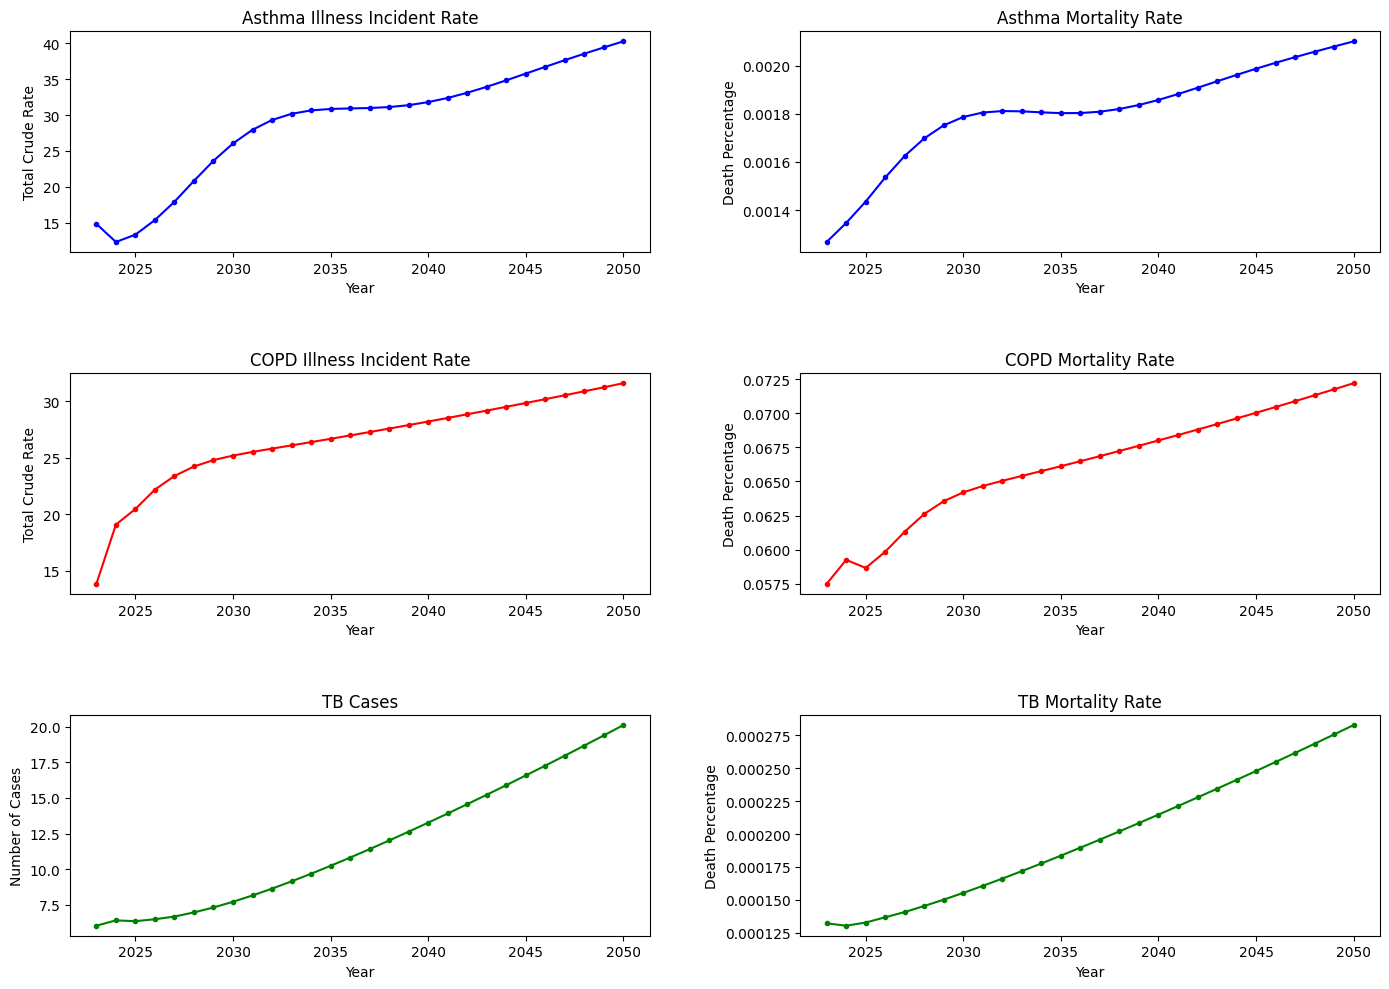

In [255]:
# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Asthma Plots
axs[0, 0].plot(future_df['Year'], future_df['Illness_crude_rate_asthma'], marker='.', color='blue')
axs[0, 0].set_title('Asthma Illness Incident Rate')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Total Crude Rate')

axs[0, 1].plot(future_df['Year'], future_df['Death_percent_asthma'], marker='.', color='blue')
axs[0, 1].set_title('Asthma Mortality Rate')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Death Percentage')

# COPD Plots
axs[1, 0].plot(future_df['Year'], future_df['Illness_crude_rate_copd'], marker='.', color='red')
axs[1, 0].set_title('COPD Illness Incident Rate')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Total Crude Rate')

axs[1, 1].plot(future_df['Year'], future_df['Death_percent_copd'], marker='.', color='red')
axs[1, 1].set_title('COPD Mortality Rate')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Death Percentage')

# TB Plots
axs[2, 0].plot(future_df['Year'], future_df['Cases_tb'], marker='.', color='green')
axs[2, 0].set_title('TB Cases')
axs[2, 0].set_xlabel('Year')
axs[2, 0].set_ylabel('Number of Cases')

axs[2, 1].plot(future_df['Year'], future_df['Death_percent_tb'], marker='.', color='green')
axs[2, 1].set_title('TB Mortality Rate')
axs[2, 1].set_xlabel('Year')
axs[2, 1].set_ylabel('Death Percentage')

# Adjust layout and display
plt.tight_layout(h_pad=4, w_pad=4)
plt.show()

We can further add 95% CI into the plots. Visualizing the 95% Confidence Interval (CI) helps to understand the uncertainty in the model’s predictions. It shows the range within which the true values are expected to fall 95% of the time, giving an idea of how reliable the forecasts are. By including the 95% CI, potential risks and variability in the predictions can be clearly identified, which is crucial for making informed decisions based on the model, given that we are woking on the model with limited fetaures and data size.

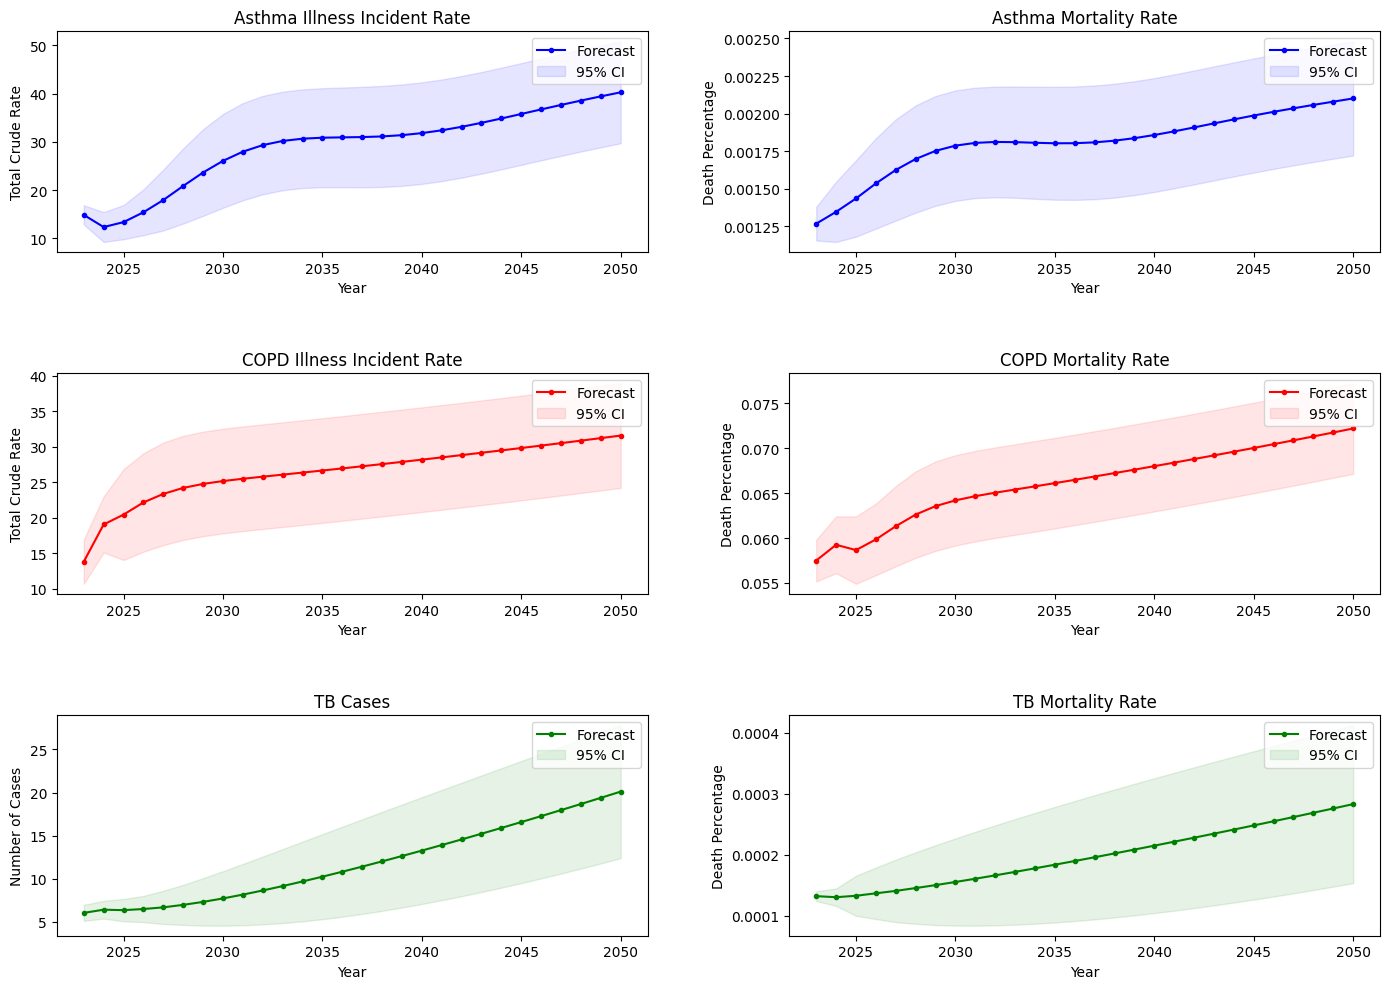

In [256]:

# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Asthma Plots
axs[0, 0].plot(future_df['Year'], future_df['Illness_crude_rate_asthma'], marker='.', color='blue', label='Forecast')
axs[0, 0].fill_between(future_df['Year'], 
                       future_df['Illness_crude_rate_asthma_lower'],
                       future_df['Illness_crude_rate_asthma_upper'],
                       alpha=0.1, color='blue', label='95% CI')
axs[0, 0].set_title('Asthma Illness Incident Rate')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Total Crude Rate')
axs[0, 0].legend()

axs[0, 1].plot(future_df['Year'], future_df['Death_percent_asthma'], marker='.', color='blue', label='Forecast')
axs[0, 1].fill_between(future_df['Year'],
                       future_df['Death_percent_asthma_lower'],
                       future_df['Death_percent_asthma_upper'],
                       alpha=0.1, color='blue', label='95% CI')
axs[0, 1].set_title('Asthma Mortality Rate')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Death Percentage')
axs[0, 1].legend()

# COPD Plots
axs[1, 0].plot(future_df['Year'], future_df['Illness_crude_rate_copd'], marker='.', color='red', label='Forecast')
axs[1, 0].fill_between(future_df['Year'],
                       future_df['Illness_crude_rate_copd_lower'],
                       future_df['Illness_crude_rate_copd_upper'],
                       alpha=0.1, color='red', label='95% CI')
axs[1, 0].set_title('COPD Illness Incident Rate')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Total Crude Rate')
axs[1, 0].legend()

axs[1, 1].plot(future_df['Year'], future_df['Death_percent_copd'], marker='.', color='red', label='Forecast')
axs[1, 1].fill_between(future_df['Year'],
                       future_df['Death_percent_copd_lower'],
                       future_df['Death_percent_copd_upper'],
                       alpha=0.1, color='red', label='95% CI')
axs[1, 1].set_title('COPD Mortality Rate')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Death Percentage')
axs[1, 1].legend()

# TB Plots
axs[2, 0].plot(future_df['Year'], future_df['Cases_tb'], marker='.', color='green', label='Forecast')
axs[2, 0].fill_between(future_df['Year'],
                       future_df['Cases_tb_lower'],
                       future_df['Cases_tb_upper'],
                       alpha=0.1, color='green', label='95% CI')
axs[2, 0].set_title('TB Cases')
axs[2, 0].set_xlabel('Year')
axs[2, 0].set_ylabel('Number of Cases')
axs[2, 0].legend()

axs[2, 1].plot(future_df['Year'], future_df['Death_percent_tb'], marker='.', color='green', label='Forecast')
axs[2, 1].fill_between(future_df['Year'],
                       future_df['Death_percent_tb_lower'],
                       future_df['Death_percent_tb_upper'],
                       alpha=0.1, color='green', label='95% CI')
axs[2, 1].set_title('TB Mortality Rate')
axs[2, 1].set_xlabel('Year')
axs[2, 1].set_ylabel('Death Percentage')
axs[2, 1].legend()

# Adjust layout and display
plt.tight_layout(h_pad=4, w_pad=4)
plt.show()

As seen in the graphs the 95% CI is very wide as we move farther from the current years, VARMAX is indicating more uncertainity as we go into future. This is expected and since our sample size is very small compared to the ratio of precitors v/s response variable, the CI will be wide. The sample size directly affects the width of the confidence interval along with the confidence level.

While this seems to be a valid and reasonable model prediction statistically, it is important to understand the extent of real-world significance of the analysis done in the notebook. We have already analyzed the correlation between smoke estimates and health indicators in our data using correlation matrix earlier. However it is important to check if the correlation is statistically significant and thereby also assessing its real world signisficance. Following code estimates p-value using pearson correlation.

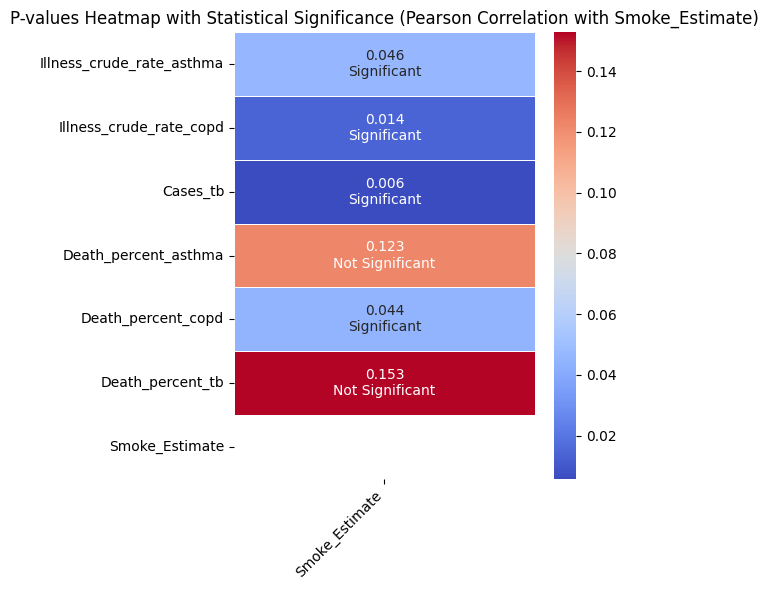

In [ ]:

df = merge_df.drop(columns=['Year']).dropna()

# Create a dataframe to store p-values
p_values = pd.DataFrame(np.zeros((df.shape[1], 1)), columns=['Smoke_Estimate'], index=df.columns)

# Compute the Pearson correlation p-values for each variable against Smoke_Estimate
for i in df.columns:
    if i != 'Smoke_Estimate':  # Avoid correlating 'Smoke_Estimate' with itself
        _, p_value = pearsonr(df[i], df['Smoke_Estimate'])
        p_values.loc[i, 'Smoke_Estimate'] = p_value
    else:
        p_values.loc[i, 'Smoke_Estimate'] = np.nan  # No correlation with itself

# Create annotations combining p-values and significance
annotations = p_values.applymap(
    lambda x: f"{x:.3f}\n{'Significant' if x < 0.05 else 'Not Significant'}" if not pd.isnull(x) else ""
)

# Plot the heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(
    p_values,
    annot=annotations,
    fmt="", 
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)

plt.title("P-values Heatmap with Statistical Significance (Pearson Correlation with Smoke_Estimate)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The p-value heatmap shows significant correlations between smoke estimates and the incidence of asthma (p = 0.046), COPD (p = 0.014), and TB (p = 0.006), suggesting a strong link between smoke exposure and these conditions. For mortality, only COPD shows a significant correlation (p = 0.044), while asthma and TB do not. However, some p-values, like those for asthma incidence (p = 0.046) and COPD mortality (p = 0.044), are close to the 0.05 threshold, meaning the results might not be robust or consistent in all situations. Real-world significance could depend on external factors such as existing health conditions, dietary habits, etc.

The entire analysis in this notebook is based on wildfires in the USA, but Madison is constantly impacted by wildfires in Canada every year due to its geographical location. Wildfires in Canada often produce large-scale smoke plumes that travel longer distances due to prevailing atmospheric winds, impacting air quality in Madison, WI, more significantly than closer U.S. wildfires. These plumes contain higher particulate matter concentrations due to the dense, boreal vegetation burned in Canadian fires. Since our analysis focuses only on smoke estimates generated purely only from U.S. wildfires, it might miss the dominant contributors to poor air quality, leading to weaker than expected correlations with respiratory health trends., as discussed above. Additionally, the temporal range of data for each health indicator is different; hence, the prediction effectiveness is likely to be different for each metric. Lastly, other confounding variables such as existing health conditions, dietary habits, exposure to toxic gases from other sources, etc. are not considered for this analysis, which could impact the model prediction adversely. The file generated or insights found in this notebook must be used or saved, disclosing these potential limitations.